# Kost Pricing

Pada notebook ini akan dilakukan analisis dalam penentuan harga kost terhadap fasilitas kost. Penentuan harga kost (atau `pricing`) menggunakan algoritma regresi *machine learning* dan juga akan dilakukan interpretasi model untuk analisis fasilitas apa saja yang paling berpengaruh terhadap penentuan harga. Selain menggunakan regresi akan dilakukan juga perbandingan penentuan harga menggunakan metode statistika sederhana seperti mencari rata-rata harga kost dengan fasilitas yang sama.

Notebook ini berangkat dari permasalahan ketika seorang pemilik kostan ingin menentukan harga kost perbulannya untuk mendapatkan keuntungan maksimal serta tetap dapat bersaing dengan harga kost lainnya.

Adapun pembahasan dalam notebook ini antara lain:
1. Persiapan dan Pembersihan Dataset
2. Eksplorasi Data
3. Persiapan Data untuk Model
4. Pembangunan Model
5. Evaluasi Model
6. Perbandingan dengan metode sederhana (atau bisa diatas, sebagai alasan kenapa dilakukan regresi?)
7. Kesimpulan

# Preprocessing Data

## Persiapan dan Pembersihan Data

**Membaca Data**

In [258]:
import pandas as pd 
import re as re # Regex

In [259]:
df = pd.read_csv('sewakost_40pages.tsv', sep="\t")

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


Kolom:
1. `name`: Nama kost
2. `url`: URL kost
3. `harga`: Harga per bulan
4. `jenis`: Jenis kost: putra, putri or campur
5. `address`: Alamat
6. `aircon`: biner, apakah kost mempunyai AC atau tidak
7. `free_wifi`: biner, apakah kost menyediakan wifi gratis atau tidak
8. `kamar_mandi_dalam`: biner, apakah kamar kost mempunyai kamar mandi dalam atau tidak
9. `fasiltas_kamar`: list fasilitas di dalam kamar
10. `fasilitas_kost`: list fasilitas bersama di gedung kost

## Drop Nilai NaN

Pada bagian ini akan dilihat apakah terdapat nilai NaN pada dataset. Jika terdapat data yang memiliki nilai NaN maka akan dihapus berhubung data tersebut tidak dapat digunakan untuk masukan model.

In [260]:
# Melihat jumlah baris dengan NaN perkolomnya
df.isnull().sum()

url                   0
nama                  0
harga                 0
jenis                14
address              14
aircon               14
free_wifi            14
kamar_mandi_dalam    14
fasilitas_kamar      14
fasilitas_kost       14
dtype: int64

In [261]:
# Menampilkan data dengan row NaN
df[df.isnull().any(axis=1)].head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
483,https://www.sewakost.com/jakarta/selatan/indek...,INDEKOS ELITE DALAM CLUSTER FULL FURNISH,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,https://www.sewakost.com/jakarta/selatan/tebet...,TEBET EXECUTIVE RESIDENCE 141,3.550.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,https://www.sewakost.com/jakarta/selatan/sewa-...,"Sewa Kost, Cilandak Barat, Jakarta Selatan",2.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt KRL Lt.Agung & Tj.Brt,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Wanita Tebet Dekat Pasar Tebet Barat dan ...,1.600.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Terlihat terdapat 14 data yang memiliki nilai `NaN` pada kolom `jenis`, `address`, `aircon`, `free_wifi`, `kamar_mandi_dalam`, `fasilitas_kamar`, `fasilitas_kost`.

Data-data tersebut akan dihapus dari dataset karena tidak berguna sebagai masukan dari model.

Kenapa tidak dilakukan imputasi terhadap nilai `NaN` misalnya mengisi kolom fasilitas untuk kos dengan harga yang sama? Dalam kasus ini, model regresi yang dibangun akan menggunakan informasi fasilitas kost dalam penentuan harga, kemudian kost dengan harga yang sama/mendekati dapat memiliki fasilitas yang berbeda-beda, sehingga menyulitkan proses imputasi missing value. Maka dari itu missing value dihapus saja. 

In [262]:
# Kode untuk drop semua baris dengan nilai NaN
df.dropna(inplace=True)

# Menampilkan jumlah baris dengan nilai NaN perkolomnya
df.isnull().sum()

url                  0
nama                 0
harga                0
jenis                0
address              0
aircon               0
free_wifi            0
kamar_mandi_dalam    0
fasilitas_kamar      0
fasilitas_kost       0
dtype: int64

Tidak terdapat lagi nilai `NaN` dalam dataset, sehingga dapat melanjutkan ke proses pengolahan data selanjutnya.

## Mengubah Format Data

### Ekstrak Numerik pada Kolom Harga

Kolom `harga` masih dalam format `Rp.[harga]`. Maka dari itu perlu dilakukan ekstraksi nilai numerik terhadap kolom `harga` untuk memudahkan analisis harga.

In [263]:
# Fungsi untuk mengambil setiap nilai numerik kemudian mengubah ke dalam bentuk integer
def find_number(text):
    try:
        # Regex \d untuk mengambil setiap nilai numerik
        num = "".join(re.findall(r'[\d]+',text))
        return int(num)
    except:
        return 0

In [264]:
# Mengubah seluruh kolom harga menjadi integer
df['harga'] = df['harga'].apply(lambda x: find_number(x))

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


kolom `harga` yang tadinya tipe data `string` (contoh: `Rp 1.000.000`) sekarang telah berubah menjadi tipe data `integer`.

### Membersihkan Data Outlier





In [265]:
df.describe()

,harga
count,9.440000e+02
mean,3.816841e+09
std,8.280764e+10
min,0.000000e+00
25%,1.000000e+06
50%,1.650000e+06
75%,2.350000e+06
max,1.800000e+12


Terdapat kost-an dengan harga yang sangat murah, termasuk yang 0 rupiah alias gratis (mungkin fasilitasnya selain kamar mandi luar juga harus tidur di luar). Selain kost-an yang sangat murah, tedapat juga kost-an yang sangat mahal hingga seharga 180 juta/bulan.

Kost-an seperti ini tidak akan dianalisis sehingga harus dikeluarkan dari dataset. 

Akan dipertahankan kost-kostan dengan harga di atas 300rb dan di bawah 5 juta. Selain dari pada itu akan dihilangkan dari dataset.

In [266]:
# Drop harga kos di bawah 300rb dan di atas 5 juta
df = df[(df['harga']>=300000) & (df['harga']<=5000000)]

df.shape

(872, 10)

### Mengubah ke Format Kategorikal

(jelasin kenapa harus diubah)

In [267]:
df['jenis'].unique()

array(['Kost Campur', 'Kost Putra', 'Kost Putri', 'Kost Pasutri',
       'Kost Keluarga'], dtype=object)

In [268]:
df.dtypes

url                  object
nama                 object
harga                 int64
jenis                object
address              object
aircon               object
free_wifi            object
kamar_mandi_dalam    object
fasilitas_kamar      object
fasilitas_kost       object
dtype: object

In [269]:
# Mengubah jenis kost pasutri -> kost keluarga
df['jenis'] = df['jenis'].replace('Kost Pasutri', 'Kost Keluarga')

# Mengubah ke dalam bentuk kategorikal
categorical = ['jenis', 'aircon', 'free_wifi', 'kamar_mandi_dalam']
df[categorical] = df[categorical].astype('category')

df.dtypes

url                    object
nama                   object
harga                   int64
jenis                category
address                object
aircon               category
free_wifi            category
kamar_mandi_dalam    category
fasilitas_kamar        object
fasilitas_kost         object
dtype: object

### Ekstrak `fasilitas_kamar` dan `fasilitas_kost` ke Dalam Kolom Dataframe

1. Get unique in `fasilitas_kamar`
2. Looping dan ekstrak setiap fasilitas
3. Fasilitas dibuat menjadi kolom baru
4. Iterasi setiap baris pada dataframe dan cek kolom fasilitas kamar (iterasi lagi per kolom fasilitas yang baru) pakai `is in` maybe. Jika ada maka `Yes` atau `1` di kolom per fasilitas.

**Fungsi untuk mengekstrak fasilitas**

(jelasin bagaimana fungsinya berjalan)

In [270]:
def get_fasilitas(data_fasilitas):
    fasilitas = []
    for n in data_fasilitas:
        data = n[1:-1]
        if data == "":
            continue
        list_fas = data.replace("'", "").split(", ")
        for fas in list_fas:
            if fas not in fasilitas:
                fasilitas.append(fas)
    
    return fasilitas

(Jelasin apa maksud output ini)

In [271]:
fasilitas_kamar = get_fasilitas(df['fasilitas_kamar'].unique())
print(fasilitas_kamar)

fasilitas_kost = get_fasilitas(df['fasilitas_kost'].unique())
print(fasilitas_kost)

['Kamar Mandi Dalam', 'Spring Bed', 'Perabot', 'Free WiFi', 'AC', 'TV', 'Pemanas Air (Water Heater)', 'Kulkas']
['Keamanan', 'Parkir Motor', 'Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Minum', 'Pembantu', 'Parkir Mobil', 'Cuci Setrika', 'Mesin Cuci (Cuci Sendiri)', 'Televisi']


(jelasin kenapa didrop)

In [272]:
# Karena sudah ada kolom untuk ini
remove_fasilitas = ['Kamar Mandi Dalam', 'AC', 'Free WiFi']

for fas in remove_fasilitas:
    fasilitas_kamar.remove(fas)

print(fasilitas_kamar)

['Spring Bed', 'Perabot', 'TV', 'Pemanas Air (Water Heater)', 'Kulkas']


(jelasin fungsi ini untuk assign per row)

In [273]:
def get_info(fas_kamar, fas):
    data = []
    for row in fas_kamar:
        status = "Ya" if fas in row else "Tidak"
        data.append(status)
    return data

In [274]:
for fas in fasilitas_kamar:
    kolom_baru = fas + "_fkamar"
    df[kolom_baru] = get_info(df['fasilitas_kamar'], fas)

for fas in fasilitas_kost:
    kolom_baru = fas + "_fkost"
    df[kolom_baru] = get_info(df['fasilitas_kost'], fas)

In [275]:
df = df.drop(['fasilitas_kamar', 'fasilitas_kost'], axis=1)

In [276]:
df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,...,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,Tidak,Tidak,...,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,Ya,Ya,...,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,Tidak,Tidak,...,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,Ya,Ya,...,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Keluarga,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,Tidak,Tidak,...,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


In [277]:
df.shape

(872, 24)

Tambahin penjelasan mengenai keluaran akhir dari data, dan juga manfaat mengapa datanya harus berbentuk ini

In [ ]:
# Menyimpan data
df.to_csv('sewakost_clean.tsv', sep="\t", index = False)

# Eksplorasi Data

In [357]:
import pandas as pd
import numpy as np

In [358]:
kost_clean = pd.read_csv('sewakost_clean.tsv', sep="\t")

kost_clean.head(5)

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,...,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,Tidak,Tidak,...,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,Ya,Ya,...,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,Tidak,Tidak,...,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,Ya,Ya,...,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Keluarga,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,Tidak,Tidak,...,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


In [359]:
kost_clean.iloc[:, 5:].head()

,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,Tidak,Tidak,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,Ya,Ya,Ya,Ya,Ya,Tidak,Ya,Tidak,Ya,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,Ya,Tidak,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


**Dijelasin kenapa diubah menjadi 1 dan 0**

In [360]:
kost_clean.iloc[:, 5:] = np.where(kost_clean.iloc[:, 5:] == 'Ya', 1, 0)

In [361]:
kost_clean.iloc[:, 5:].head()

,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0


In [362]:
kost_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   url                                872 non-null    object
 1   nama                               872 non-null    object
 2   harga                              872 non-null    int64 
 3   jenis                              872 non-null    object
 4   address                            872 non-null    object
 5   aircon                             872 non-null    int64 
 6   free_wifi                          872 non-null    int64 
 7   kamar_mandi_dalam                  872 non-null    int64 
 8   Spring Bed_fkamar                  872 non-null    int64 
 9   Perabot_fkamar                     872 non-null    int64 
 10  TV_fkamar                          872 non-null    int64 
 11  Pemanas Air (Water Heater)_fkamar  872 non-null    int64 
 12  Kulkas_f

In [363]:
kost_clean.describe()

,harga,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
count,8.720000e+02,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,1.825345e+06,0.743119,0.737385,0.790138,0.597477,0.447248,0.228211,0.215596,0.144495,0.388761,0.643349,0.395642,0.260321,0.508028,0.290138,0.178899,0.315367,0.147936,0.111239,0.176606
std,9.535121e+05,0.437164,0.440307,0.407444,0.490688,0.497495,0.419920,0.411471,0.351793,0.487749,0.479286,0.489269,0.439062,0.500222,0.454086,0.383488,0.464929,0.355240,0.314608,0.381553
min,4.000000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.650000e+06,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.300000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [364]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='harga'>

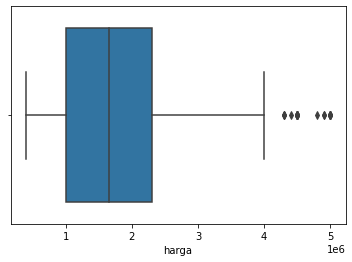

In [365]:
sns.boxplot(x=kost_clean['harga'])

In [366]:
Q1 = kost_clean.harga.quantile(0.25)
Q3 = kost_clean.harga.quantile(0.75)
IQR = Q3-Q1

outlier_bawah = kost_clean[kost_clean['harga'] < (Q1 - 1.5 * IQR)]
outlier_atas = kost_clean[kost_clean['harga'] > (Q3 + 1.5 * IQR)]

print("Jumlah kos lengkap dengan harga di bawah %i adalah = %i" % ((Q1 - 1.5 * IQR), outlier_bawah.shape[0]))
print("Jumlah kos lengkap dengan harga di atas %i adalah = %i" % ((Q3 + 1.5 * IQR), outlier_atas.shape[0]))

Jumlah kos lengkap dengan harga di bawah -950000 adalah = 0
Jumlah kos lengkap dengan harga di atas 4250000 adalah = 26


<AxesSubplot:xlabel='harga'>

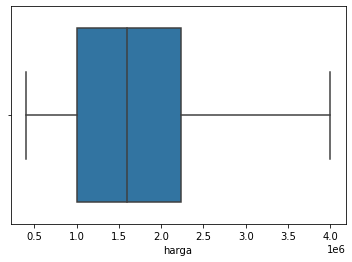

In [367]:
kost_clean = kost_clean[kost_clean['harga']<=(Q3 + 1.5 * IQR)]

sns.boxplot(x=kost_clean['harga'])

In [368]:
correlation_matrix = kost_clean.corr().round(2)

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

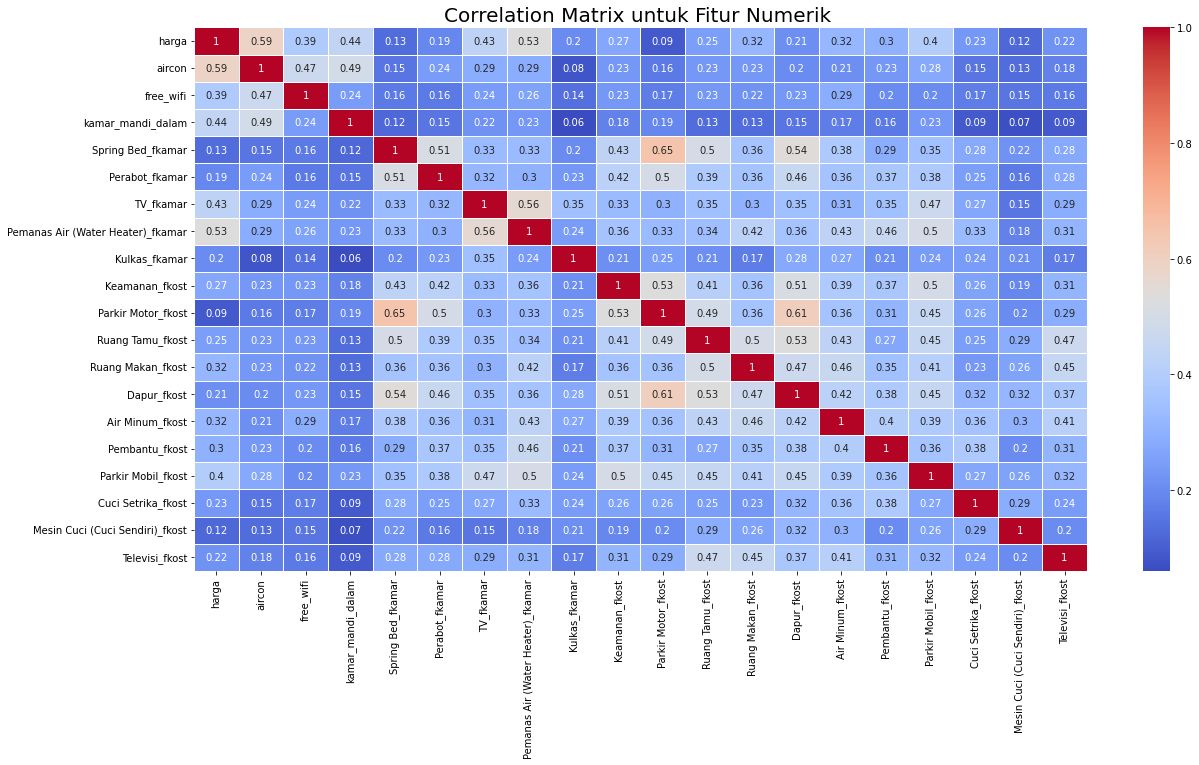

In [369]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriks Korelasi Terhadap Fitur Numerik", size=20)

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

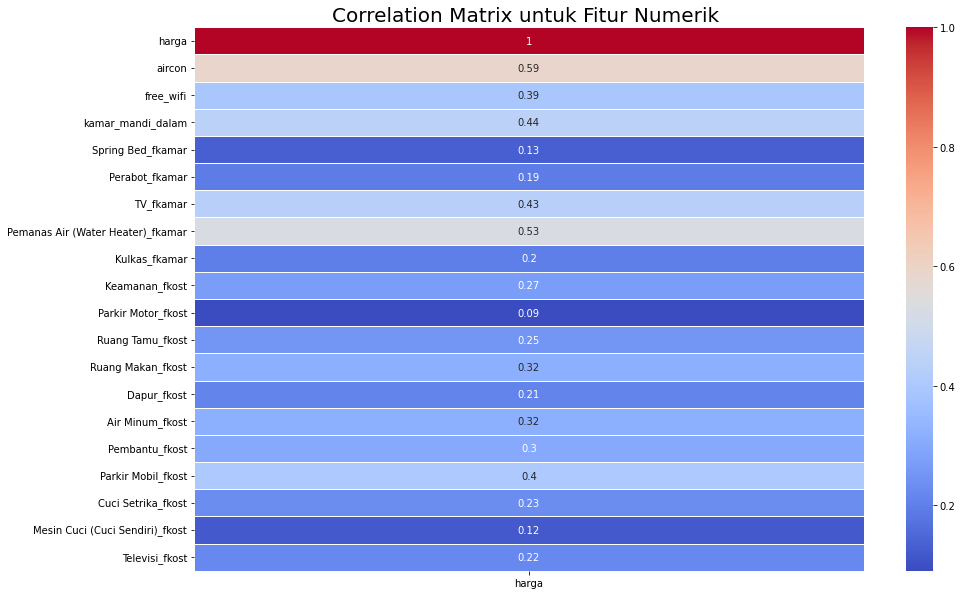

In [370]:
korelasi_harga = correlation_matrix[['harga']]
plt.figure(figsize=(15, 10))
sns.heatmap(data=korelasi_harga, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korelasi Fasilitas Terhadap Harga Kost", size=20)

In [371]:
# Mempertahankan feature dengan korelasi di atas 0.25
korelasi_tinggi = korelasi_harga[korelasi_harga['harga'] >= 0.25]

korelasi_tinggi

,harga
harga,1.00
aircon,0.59
free_wifi,0.39
kamar_mandi_dalam,0.44
TV_fkamar,0.43
Pemanas Air (Water Heater)_fkamar,0.53
Keamanan_fkost,0.27
Ruang Tamu_fkost,0.25
Ruang Makan_fkost,0.32
Air Minum_fkost,0.32


In [372]:
len(korelasi_harga.index.to_list())

20

In [373]:
kost_clean.groupby(kost_clean['jenis'])[['harga']].mean()

,harga
jenis,
Kost Campur,1.984307e+06
Kost Keluarga,2.814286e+06
Kost Putra,1.212890e+06
Kost Putri,1.432681e+06


In [374]:
from sklearn.preprocessing import OneHotEncoder

# Mendapatkan nama kolom hasil one hot
kolom_oneHot = pd.get_dummies(kost_clean['jenis'], prefix='jenis').columns.to_list()
# Melakukan one hot encoding untuk kolom jenis
kost_clean = pd.concat([kost_clean, pd.get_dummies(kost_clean['jenis'], prefix='jenis')], axis=1)
# Drop kolom jenis (kolom asal untuk one hot)
kost_clean.drop(['jenis'], axis=1, inplace=True)

In [375]:
# Subset kolom yang memiliki korelasi tinggi + kolom hasil dummy jenis kost
kost_clean_korelasi = kost_clean[korelasi_tinggi.index.to_list() + kolom_oneHot]

kost_clean_korelasi.head()

,harga,aircon,free_wifi,kamar_mandi_dalam,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Keamanan_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,jenis_Kost Campur,jenis_Kost Keluarga,jenis_Kost Putra,jenis_Kost Putri
0,1000000,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,2200000,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0
2,850000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2700000,1,1,1,0,1,1,0,0,0,1,0,0,0,0,1
4,2500000,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0


In [376]:
# Subset semua kolom dengan fitur numerik dari korelasi harga + variabel dummy dari jenis kost
kost_clean_all = kost_clean[korelasi_harga.index.to_list() + kolom_oneHot]

kost_clean_all.head()

,harga,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,...,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost,jenis_Kost Campur,jenis_Kost Keluarga,jenis_Kost Putra,jenis_Kost Putri
0,1000000,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,2200000,1,1,1,1,1,1,0,0,0,...,1,1,1,0,0,0,0,0,1,0
2,850000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2700000,1,1,1,1,1,0,1,0,1,...,0,1,0,1,0,0,0,0,0,1
4,2500000,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [377]:
# Pembagian data latih dan data uji
from sklearn.model_selection import train_test_split

# # Untuk korelasi tinggi
# X = kost_clean_korelasi.drop(['harga'], axis=1)
# y = kost_clean_korelasi['harga']

# Untuk semua feature
X = kost_clean_all.drop(['harga'], axis=1)
y = kost_clean_all['harga']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [378]:
print(f"""
Total Dataset: {len(X)}
Train Dataset: {len(X_train)}
Test Dataset: {len(X_test)}
""")


Total Dataset: 846
Train Dataset: 676
Test Dataset: 170



In [379]:
models = pd.DataFrame(
    index=['train_mae', 'test_mae'],
    columns=['LinearRegression', 'RandomForest', 'Boosting'])

In [380]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [381]:
model_lr = LinearRegression().fit(X_train, y_train)

In [382]:
r_sq = model_lr.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.6150895887129206


In [383]:
y_pred_A = model_lr.predict(X_train)

y_pred_A[:5]

array([1863575.33487774, 1064930.30859756,  994556.22643506,
       2053343.12051065, 1079636.64293962])

In [384]:
r2 = r2_score(y_train, y_pred_A)
print('r2 score model is', r2)

r2 score model is 0.6150895887129206


In [385]:
def adjr(r2, n, predictor_length):
  return 1-(1-r2)*(n-1)/(n-predictor_length-1)

In [386]:
adjr2_B = adjr(r2, len(y_train), 19)
print('adjusted r2 score model_B is', adjr2_B)

adjusted r2 score model_B is 0.603941268873813


In [387]:
model_lr.intercept_

1094272.6345881694

In [388]:
model_lr.coef_

array([ 601224.74504903,  184915.50478592,  263003.95804454,
        -35086.78368009,  -59884.2674734 ,  149173.0201001 ,
        503512.06231184,  125810.68368206,   38828.61092538,
       -366718.33993302,   25379.08244678,  174141.14602248,
         29323.39109112,   76321.79151326,  -58406.61534459,
        196724.04574819,  129158.47937247,  -99689.18704711,
        -82033.31444935,  -90073.72195701,  664713.66290022,
       -279841.50758992, -294798.43335329])

In [389]:
model_lr.feature_names_in_

array(['aircon', 'free_wifi', 'kamar_mandi_dalam', 'Spring Bed_fkamar',
       'Perabot_fkamar', 'TV_fkamar', 'Pemanas Air (Water Heater)_fkamar',
       'Kulkas_fkamar', 'Keamanan_fkost', 'Parkir Motor_fkost',
       'Ruang Tamu_fkost', 'Ruang Makan_fkost', 'Dapur_fkost',
       'Air Minum_fkost', 'Pembantu_fkost', 'Parkir Mobil_fkost',
       'Cuci Setrika_fkost', 'Mesin Cuci (Cuci Sendiri)_fkost',
       'Televisi_fkost', 'jenis_Kost Campur', 'jenis_Kost Keluarga',
       'jenis_Kost Putra', 'jenis_Kost Putri'], dtype=object)

In [390]:
# Impor library yang dibutuhkan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
 
# buat model prediksi
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=50, n_jobs=-1, random_state=55)

In [391]:
from sklearn.ensemble import AdaBoostRegressor
 
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)                             
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

In [ ]:
# Buat variabel mse yang isinya adalah dataframe nilai mse data train dan test pada masing-masing algoritma
mae = pd.DataFrame(columns=['train', 'test'], index=['LinearRegression','RF','Boosting'])
 
# Buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'LinearRegression': model_lr, 'RF': RF, 'Boosting': boosting}
 
# Hitung Mean Squared Error masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    mae.loc[name, 'train'] = round(mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train)))
    mae.loc[name, 'test'] = round(mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test)))

# Panggil mae
mae

,train,test
LinearRegression,391944,407190
RF,276808,387017
Boosting,411140,432150


In [392]:
# Buat variabel mse yang isinya adalah dataframe nilai mse data train dan test pada masing-masing algoritma
mae = pd.DataFrame(columns=['train', 'test'], index=['LinearRegression','RF','Boosting'])
 
# Buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'LinearRegression': model_lr, 'RF': RF, 'Boosting': boosting}
 
# Hitung Mean Squared Error masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    mae.loc[name, 'train'] = round(mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train)))
    mae.loc[name, 'test'] = round(mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test)))

# Panggil mae
mae

,train,test
LinearRegression,386210,397308
RF,217547,428436
Boosting,402309,427249


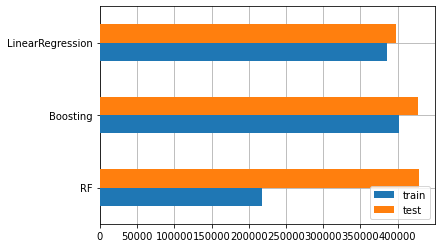

In [393]:
fig, ax = plt.subplots()
mae.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

<AxesSubplot:xlabel='harga'>

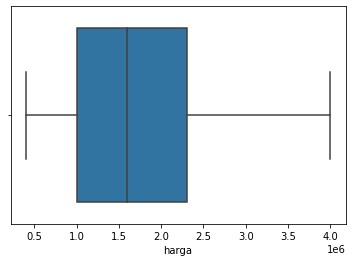

In [394]:
sns.boxplot(x=y_train)

<AxesSubplot:>

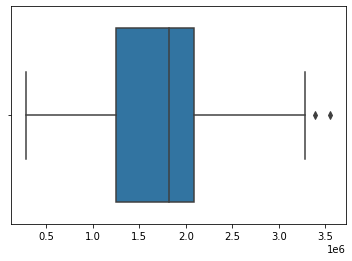

In [395]:
sns.boxplot(x=model_lr.predict(X_train))

<AxesSubplot:>

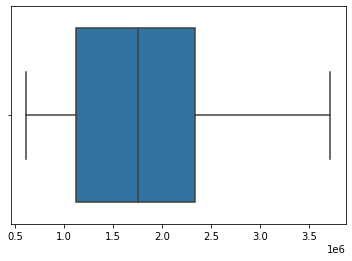

In [396]:
sns.boxplot(x=RF.predict(X_train))

<AxesSubplot:>

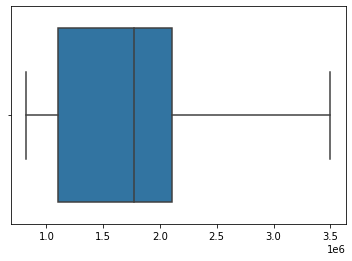

In [397]:
sns.boxplot(x=boosting.predict(X_train))

In [398]:
dir(boosting)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_boost',
 '_check_X',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_median_predict',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_validate_data',
 '_validate_estimator',
 'base_estimator',
 'base_estimator_',
 'estimator_errors_',
 'estimator_params',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_par

In [399]:
dir(RF)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 

In [400]:
boosting.feature_importances_

array([5.93881323e-01, 1.49397813e-02, 1.58522454e-02, 1.48211852e-02,
       0.00000000e+00, 1.44912302e-02, 2.02134789e-01, 4.71052078e-03,
       1.20433216e-03, 3.20065176e-02, 0.00000000e+00, 9.41945427e-04,
       5.14149731e-04, 8.91995392e-05, 0.00000000e+00, 6.91878133e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.33886375e-02,
       5.84173392e-02, 1.32919034e-02, 1.23961194e-02])

In [401]:
boosting.feature_names_in_

array(['aircon', 'free_wifi', 'kamar_mandi_dalam', 'Spring Bed_fkamar',
       'Perabot_fkamar', 'TV_fkamar', 'Pemanas Air (Water Heater)_fkamar',
       'Kulkas_fkamar', 'Keamanan_fkost', 'Parkir Motor_fkost',
       'Ruang Tamu_fkost', 'Ruang Makan_fkost', 'Dapur_fkost',
       'Air Minum_fkost', 'Pembantu_fkost', 'Parkir Mobil_fkost',
       'Cuci Setrika_fkost', 'Mesin Cuci (Cuci Sendiri)_fkost',
       'Televisi_fkost', 'jenis_Kost Campur', 'jenis_Kost Keluarga',
       'jenis_Kost Putra', 'jenis_Kost Putri'], dtype=object)

In [402]:
RF.feature_importances_

array([0.4054059 , 0.03112724, 0.01703417, 0.02321675, 0.01866791,
       0.02572502, 0.15400439, 0.01824487, 0.01495716, 0.03147885,
       0.02274523, 0.02505437, 0.0129049 , 0.02186896, 0.01511917,
       0.02312601, 0.01495791, 0.01440355, 0.01694178, 0.0225806 ,
       0.0379435 , 0.01619189, 0.01629987])

In [403]:
RF.feature_names_in_

array(['aircon', 'free_wifi', 'kamar_mandi_dalam', 'Spring Bed_fkamar',
       'Perabot_fkamar', 'TV_fkamar', 'Pemanas Air (Water Heater)_fkamar',
       'Kulkas_fkamar', 'Keamanan_fkost', 'Parkir Motor_fkost',
       'Ruang Tamu_fkost', 'Ruang Makan_fkost', 'Dapur_fkost',
       'Air Minum_fkost', 'Pembantu_fkost', 'Parkir Mobil_fkost',
       'Cuci Setrika_fkost', 'Mesin Cuci (Cuci Sendiri)_fkost',
       'Televisi_fkost', 'jenis_Kost Campur', 'jenis_Kost Keluarga',
       'jenis_Kost Putra', 'jenis_Kost Putri'], dtype=object)